# Interpolation

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from math import cos, sin
from math import sqrt

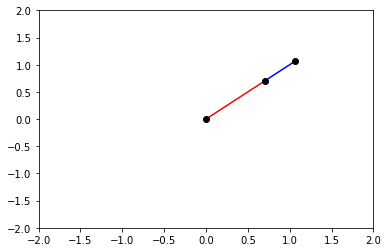

In [98]:
class TwoLinkArm:
    def __init__(self, joint_angles= [0, 0]):
        self.shoulder = np.array([0, 0])
        self.link_lengths = [1, 0.5]
        self.update_joints(joint_angles)
        
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.forward_kinematics()
        
    def forward_kinematics(self):
        theta0 = self.joint_angles[0]
        theta1 = self.joint_angles[1]
        l0 = self.link_lengths[0]
        l1 = self.link_lengths[1]
        self.elbow = self.shoulder + np.array([l0 * cos(theta0), l0 * sin(theta0)])
        self.wrist = self.elbow + np.array([l1 * cos(theta0 + theta1), l1 * sin(theta0 + theta1)])
        
#         print("x1, y1", self.elbow)
#         print("x2, y2", self.wrist)

        
    def inverse_kinematics(self, x, y):
        theta1 = np.pi - np.arccos((self.link_lengths[0]**2 + self.link_lengths[1]**2 - x**2 - y**2) / (2*self.link_lengths[0]*self.link_lengths[1]))
        theta0 = np.arctan2(y, x) - np.arccos((self.link_lengths[0]**2 + x**2 + y**2 - self.link_lengths[1]**2) / (2*self.link_lengths[0]*((x**2 + y**2)**0.5)))
        return [theta0, theta1]
#         print("theta0: ", theta0)
#         print("theta1: ", theta1)
        
    def plot(self):
        plt.axis([-2,2,-2,2])
        plt.plot([self.shoulder[0], self.elbow[0]], [self.shoulder[1], self.elbow[1]], 'r-')
        plt.plot([self.elbow[0], self.wrist[0]], [self.elbow[1], self.wrist[1]], 'b-')
        plt.plot(self.shoulder[0], self.shoulder[1], 'ko')
        plt.plot(self.elbow[0], self.elbow[1], 'ko')
        plt.plot(self.wrist[0], self.wrist[1], 'ko')
 

arm = TwoLinkArm([pi/4, 0])
arm.plot()

interactive(children=(IntSlider(value=12, description='sim_t', max=25), Output(layout=Layout(height='300px')))…

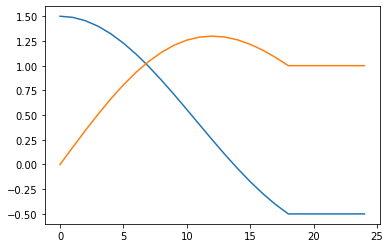

In [108]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

t = 25

# assume joint0 and joint1 are able to rotate 30 degree per unit time
joint_max_rad = 5 / 180 * np.pi
# print(joint_max_rad)


current_theta = np.zeros((t,2))
arm = TwoLinkArm(current_theta[0])
current_position = np.zeros((t,2))
# desired_theta = np.array([pi/2, pi])
desired_position = [-0.5, 1]
desired_theta = arm.inverse_kinematics(desired_position[0], desired_position[1])
dif_theta = np.zeros((t,2))

dt = np.arange(0, t)


for i in range(t):
    dif_theta[i] = desired_theta - current_theta[i]
    dif_theta[i] = np.where(dif_theta[i] > joint_max_rad, joint_max_rad, dif_theta[i])
    if i < t-1:
        current_theta[i+1] = current_theta[i] + dif_theta[i] 
    arm.update_joints(current_theta[i])
    current_position[i] = arm.wrist

fig = plt.figure()
ax = plt.axes()
# ax.set_xlim(0, 5); ax.set_ylim(0, 2);
ax.plot(dt, current_position[:])
# print(current_position)

def iterpolation(sim_t):    
    arm.update_joints(current_theta[sim_t])
    print("current end position", arm.wrist)
    arm.plot()
    

    
interactive_plot = interactive(iterpolation, sim_t=(0, 25, 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

# Speed Profile: Shock-free and Jerk-limited

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from math import cos, sin
from math import sqrt

### Given parameters: 
***a_max***

***v_max***

***s_total***

In [5]:
# Set parameters
a_max = 2 # m/(s**2)
v_max = 2 # m/s
s_total = 5 # m

# acceleration time can be determined from a_max and v_max
t_acc = 1.5 * (v_max / a_max)

## Phase 1: acceleration profile

Gien a_max and t_acc, we are able to calcultae the interpolation params.

**Assume acceleration function a(t) = At<sup>2</sup> + Bt + C**

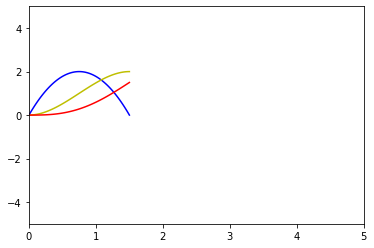

In [6]:
t = np.linspace(0, t_acc, 100)

a_1 = (-4*a_max) * (t**2) / (t_acc**2)  + (4*a_max) * t / (t_acc)
v_1 = (-4*a_max) * (t**3)/ (3*(t_acc**2)) + (4*a_max) * (t**2) / (2*t_acc)
s_1 = (2*a_max*(t**3)*t_acc - a_max*(t**4)) / (3*(t_acc**2))

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
ax.plot(t, a_1, 'b')
ax.plot(t, v_1, 'y')
ax.plot(t, s_1, 'r')

## Phase 2: Plateau state

t_plateau:  1.0


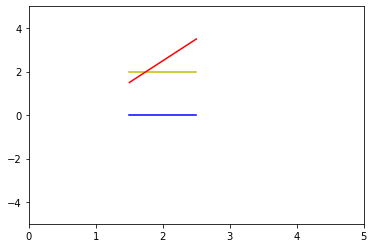

In [7]:
t_plateau = (s_total - 2*s_1[-1])/v_max
print("t_plateau: ", t_plateau)

t = np.linspace(t_acc,t_plateau + t_acc, 100)
a_2 = 0*t
v_2 = v_max * np.ones((t.shape))
s_2 = s_1[-1] + v_max * (t - t_acc)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
ax.plot(t, a_2, 'b')
ax.plot(t, v_2, 'y')
ax.plot(t, s_2, 'r')

## Phase 3: Braking Phase

Since the equation is too complicated. I use the inverted phase1 as workaround.

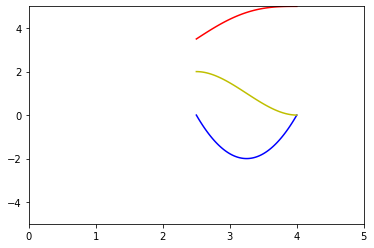

In [8]:
# t = np.linspace(t_acc + t_plateau, t_acc + t_plateau + t_acc, 100)
t = np.linspace(0, t_acc, 100)


# a_3 = (4*a_max*(t_plateau**2))/(t_acc**2) + (12*a_max*t_plateau)/t_acc - (8*a_max*t*t_plateau)/(t_acc**2) - (12*a_max*t)/t_acc + (4*a_max*(t**2))/(t_acc**2) + 8*a_max
# v_3 = -(4*a_max*(t_plateau**3))/(3*t_acc**2) - (6*a_max*(t_plateau**2))/t_acc + (4*a_max*t*(t_plateau**2))/(t_acc**2) + (12*a_max*t*t_plateau)/t_acc - (4*a_max*(t**2)*t_plateau)/(t_acc**2) - 8*a_max*t_plateau - 8*a_max*t_acc/3 - 6*a_max*(t**2)/t_acc + 4*a_max*(t**3)/(3*(t_acc**2)) + 8*a_max*t

a_3 = -(-4*a_max) * (t**2) / (t_acc**2)  - (4*a_max) * t / (t_acc)
v_3 = v_2[-1] - ((-4*a_max) * (t**3)/ (3*(t_acc**2)) + (4*a_max) * (t**2) / (2*t_acc))
s_3 = s_2[-1] + v_2[-1]*t - ((-a_max) * (t**4)/ (3*(t_acc**2)) + (4*a_max) * (t**3) / (6*t_acc))

t = np.linspace(t_acc + t_plateau, t_acc + t_plateau + t_acc, 100)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
ax.plot(t, a_3, 'b')
ax.plot(t, v_3, 'y')
ax.plot(t, s_3, 'r')

## Overall profile

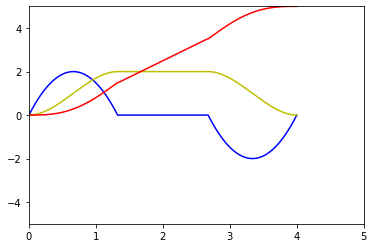

In [9]:
t = np.linspace(0, 2*t_acc+t_plateau, 300)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
a = np.concatenate((a_1, a_2, a_3))
v = np.concatenate((v_1, v_2, v_3))
s = np.concatenate((s_1, s_2, s_3))
ax.plot(t, a, 'b')
ax.plot(t, v, 'y')
ax.plot(t, s, 'r')